<ipython-input-11-95c1c8540911>:48: RuntimeWarning: divide by zero encountered in log
  self.y * np.log(p[:, i]) + (1 - self.y) * np.log(1 - p[:, i])
<ipython-input-11-95c1c8540911>:56: RuntimeWarning: invalid value encountered in subtract
  np.mean(np.exp(log_lik_particles - max_loglik))
<ipython-input-11-95c1c8540911>:48: RuntimeWarning: invalid value encountered in multiply
  self.y * np.log(p[:, i]) + (1 - self.y) * np.log(1 - p[:, i])


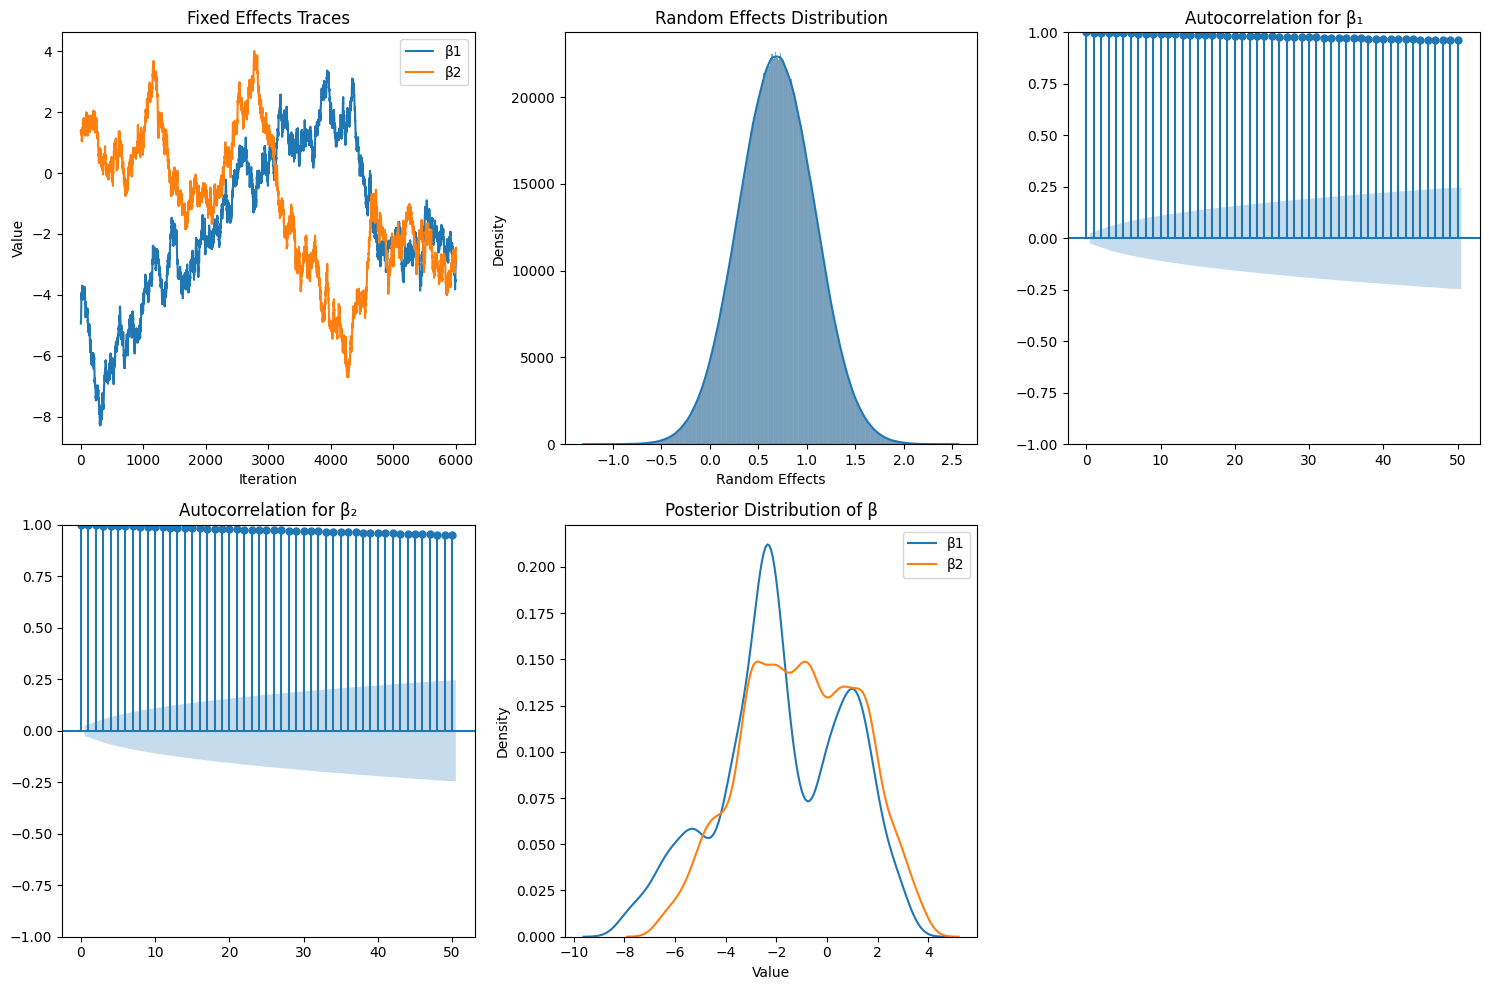

Beta samples shape: (6000, 8)
Random effects samples shape: (6000, 500)

Mean estimates:
Beta mean: [-1.76342206 -1.03531967 -8.88787019 -8.60791039  4.21300697 -2.03501703
 -5.16746924  3.7069777 ]
Random effects mean: [0.70079001 0.6629759  0.72499841 0.6897739  0.66581161 0.68203519
 0.71692078 0.64107326 0.62460339 0.72417332 0.71673492 0.70132625
 0.75239798 0.72199472 0.71254655 0.71963346 0.6307313  0.75415499
 0.60628283 0.72404644 0.60903122 0.6933273  0.67746469 0.72682572
 0.71069514 0.67470014 0.68373677 0.64423611 0.66824109 0.66001823
 0.75944769 0.62197606 0.67507025 0.67745979 0.69566835 0.71731629
 0.69162056 0.63820851 0.66429764 0.69910243 0.6510459  0.68706258
 0.69298387 0.66946749 0.72898976 0.66875779 0.65812058 0.68657074
 0.66349107 0.70617817 0.67336923 0.69846377 0.67494277 0.71916701
 0.66700196 0.70020264 0.70382175 0.65403213 0.70061391 0.70025698
 0.74973557 0.65451537 0.66709721 0.71619248 0.69806087 0.64470638
 0.68278738 0.76478661 0.65599252 0.6707912

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

class PseudoMarginalGLMM:
    def __init__(self, X, y, n_subjects, n_covariates, n_obs_per_subject=6, n_particles=128):
        """
        Initialize GLMM model
        """
        self.X = X
        self.y = y
        self.n_subjects = n_subjects
        self.n_covariates = n_covariates
        self.n_obs_per_subject = n_obs_per_subject
        self.n_particles = n_particles

        # Subject indices for mapping random effects
        self.subject_indices = np.repeat(np.arange(n_subjects), n_obs_per_subject)

        # Initial parameter guesses
        self.beta = np.random.normal(0, 0.1, n_covariates)
        self.mixture_weights = np.array([0.5, 0.5])
        self.mixture_means = np.array([0.0, 3.0])
        self.mixture_precisions = np.array([10.0, 3.0])

    def importance_sampling_likelihood(self, beta, random_effects):
        """
        Improved Importance Sampling-Based Likelihood Approximation
        """
        # Sample auxiliary variables from standard normal
        auxiliary_vars = np.random.normal(0, 1, (self.n_subjects, self.n_particles))

        # Perturb random effects using sampled auxiliary variables
        sampled_random_effects = random_effects[:, np.newaxis] + auxiliary_vars

        # Compute linear predictor for all particles
        linear_predictor = sampled_random_effects[self.subject_indices] + \
                           self.X @ beta.reshape(-1, 1)

        # Logistic link function
        p = 1 / (1 + np.exp(-linear_predictor))

        # Compute log-likelihood for each particle
        log_lik_particles = np.zeros(self.n_particles)
        for i in range(self.n_particles):
          log_lik_particles[i] = np.sum(
              self.y * np.log(p[:, i]) + (1 - self.y) * np.log(1 - p[:, i])
          )



        # Log-Sum-Exp for stability
        max_loglik = np.max(log_lik_particles)
        return max_loglik + np.log(
            np.mean(np.exp(log_lik_particles - max_loglik))
        )

    def leapfrog_step(self, beta, random_effects, momentum_beta, momentum_re, step_size):
        """
        Leapfrog integration step
        """
        # Half step for momentum
        momentum_beta_half = momentum_beta - 0.5 * step_size * self.log_prior_gradient(beta)
        momentum_re_half = momentum_re - 0.5 * step_size * self.log_re_prior_gradient(random_effects)

        # Full step for position
        beta_new = beta + step_size * momentum_beta_half
        re_new = random_effects + step_size * momentum_re_half

        # Half step for momentum
        momentum_beta_new = momentum_beta_half - 0.5 * step_size * self.log_prior_gradient(beta_new)
        momentum_re_new = momentum_re_half - 0.5 * step_size * self.log_re_prior_gradient(re_new)

        return beta_new, re_new, momentum_beta_new, momentum_re_new

    def hamiltonian(self, beta, random_effects, momentum_beta, momentum_re):
        """
        Compute Hamiltonian
        """
        # Kinetic energy
        kinetic_energy = 0.5 * (
            np.sum(momentum_beta**2) +
            np.sum(momentum_re**2)
        )

        # Potential energy
        potential_energy = -(
            self.log_prior(beta) +
            self.importance_sampling_likelihood(beta, random_effects) +
            self.log_random_effects_prior(random_effects)
        )

        return kinetic_energy - potential_energy

    def log_prior(self, beta):
        """
        Gaussian prior for fixed effects
        """
        return -0.5 * np.sum(beta**2 / 10000)

    def log_prior_gradient(self, beta):
        """
        Gradient of log prior
        """
        return -beta / 10000

    def log_random_effects_prior(self, random_effects):
        """
        Gaussian mixture prior for random effects
        """
        # Compute log-density for each mixture component
        log_densities = [
            -0.5 * self.mixture_precisions[k] *
            ((random_effects - self.mixture_means[k])**2)
            for k in range(2)
        ]

        # Log-sum-exp for mixture components
        max_log_density = np.max(log_densities, axis=0)
        log_mixture = max_log_density + np.log(
            self.mixture_weights[0] * np.exp(log_densities[0] - max_log_density) +
            self.mixture_weights[1] * np.exp(log_densities[1] - max_log_density)
        )

        return np.sum(log_mixture)

    def log_re_prior_gradient(self, random_effects):
        """
        Gradient of random effects prior
        """
        return self.mixture_precisions[0] * (random_effects - self.mixture_means[0]) * self.mixture_weights[0] + \
               self.mixture_precisions[1] * (random_effects - self.mixture_means[1]) * self.mixture_weights[1]

    def pm_hmc_sample(self, n_iter=7000, n_warmup=1000, step_size=0.01):
        """
        Pseudo-Marginal Hamiltonian Monte Carlo sampling
        """
        beta_samples, re_samples = [], []

        # Initialize current state
        current_beta = np.random.normal(0, 0.1, self.n_covariates)
        current_re = np.random.normal(0, 1, self.n_subjects)

        for iteration in range(n_iter):
            # Sample momentum
            momentum_beta = np.random.normal(0, 1, current_beta.shape)
            momentum_re = np.random.normal(0, 1, current_re.shape)

            # Propose new state using Leapfrog steps
            proposed_beta = current_beta.copy()
            proposed_re = current_re.copy()

            # Multiple leapfrog steps
            for _ in range(10):
                proposed_beta, proposed_re, momentum_beta, momentum_re = self.leapfrog_step(
                    proposed_beta, proposed_re,
                    momentum_beta, momentum_re,
                    step_size
                )

            # Compute Hamiltonian
            current_H = self.hamiltonian(
                current_beta, current_re,
                momentum_beta, momentum_re
            )
            proposed_H = self.hamiltonian(
                proposed_beta, proposed_re,
                momentum_beta, momentum_re
            )

            # Improved acceptance probability
            delta_H = current_H - proposed_H
            accept_prob = min(1.0, np.exp(max(-100, min(100, delta_H))))

            # Accept/reject
            if np.random.random() < accept_prob:
                current_beta = proposed_beta
                current_re = proposed_re

            # Store samples
            if iteration >= n_warmup:
                beta_samples.append(current_beta)
                re_samples.append(current_re)

        return np.array(beta_samples), np.array(re_samples)

def generate_glmm_data(n_subjects=500, n_obs_per_subject=6, n_covariates=8):
    """
    Generate synthetic data for GLMM
    """
    # True parameters
    true_beta = np.random.randn(n_covariates)
    true_mixture_means = [0, 3]
    true_mixture_precisions = [10, 3]
    true_mixture_weights = [0.8, 0.2]

    # Generate covariates
    X = np.random.randn(n_subjects * n_obs_per_subject, n_covariates)

    # Generate random effects from mixture
    mixture_idx = np.random.choice(
        2, size=n_subjects,
        p=true_mixture_weights
    )
    random_effects = np.zeros(n_subjects)
    for k in range(2):
        mask = mixture_idx == k
        random_effects[mask] = np.random.normal(
            true_mixture_means[k],
            1/np.sqrt(true_mixture_precisions[k]),
            size=np.sum(mask)
        )

    # Generate response
    linear_predictor = X @ true_beta + np.repeat(random_effects, n_obs_per_subject)
    probs = 1 / (1 + np.exp(-linear_predictor))
    y = (np.random.random(len(probs)) < probs).astype(float)

    return X, y, random_effects, true_beta

def plot_pm_hmc_results(beta_samples, re_samples):
    """
    Create enhanced diagnostic plots similar to Alenlov's Figure 4
    """
    plt.figure(figsize=(15, 10))

    # Trace plots for β parameters
    plt.subplot(231)
    for i in range(2):  # Plot first two beta parameters
        plt.plot(beta_samples[:, i], label=f'β{i+1}')
    plt.title('Fixed Effects Traces')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()

    # Histogram of random effects
    plt.subplot(232)
    sns.histplot(re_samples.flatten(), kde=True)
    plt.title('Random Effects Distribution')
    plt.xlabel('Random Effects')
    plt.ylabel('Density')

    # Autocorrelation for first two β parameters
    plt.subplot(233)
    sm.graphics.tsa.plot_acf(beta_samples[:, 0], lags=50, ax=plt.gca())
    plt.title('Autocorrelation for β₁')

    plt.subplot(234)
    sm.graphics.tsa.plot_acf(beta_samples[:, 1], lags=50, ax=plt.gca())
    plt.title('Autocorrelation for β₂')

    # Posterior distribution of β parameters
    plt.subplot(235)
    for i in range(2):
        sns.kdeplot(beta_samples[:, i], label=f'β{i+1}')
    plt.title('Posterior Distribution of β')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Generate data
    X, y, true_random_effects, true_beta = generate_glmm_data()

    # Initialize and run PM-HMC
    model = PseudoMarginalGLMM(
        X, y,
        n_subjects=500,
        n_covariates=8,
        n_obs_per_subject=6,
        n_particles=128
    )

    beta_samples, re_samples = model.pm_hmc_sample()

    # Plot results
    plot_pm_hmc_results(beta_samples, re_samples)

    # Print some diagnostics
    print("Beta samples shape:", beta_samples.shape)
    print("Random effects samples shape:", re_samples.shape)
    print("\nMean estimates:")
    print("Beta mean:", np.mean(beta_samples, axis=0))
    print("Random effects mean:", np.mean(re_samples, axis=0))